In [3]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.2
torchvision version: 0.17.2


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


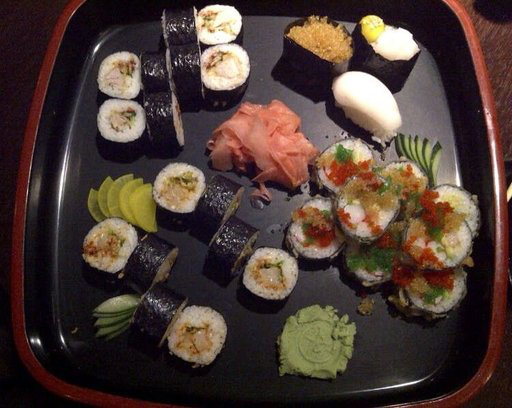

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    #transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

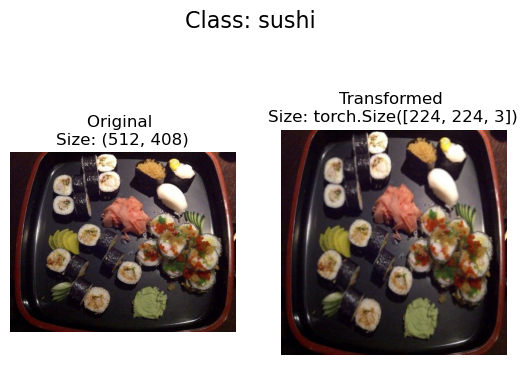

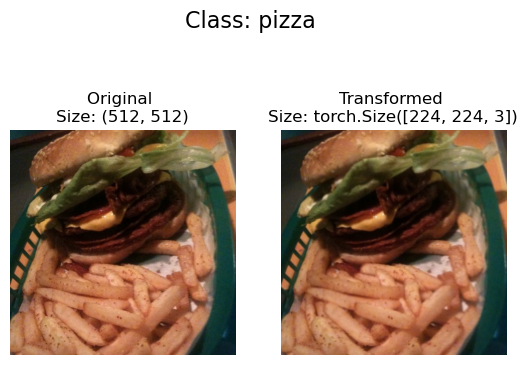

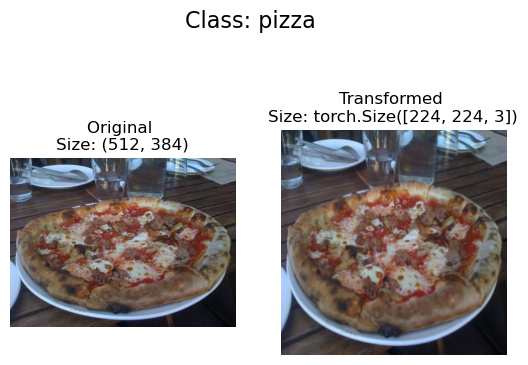

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1176, 0.1137],
         [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1176],
         [0.1216, 0.1255, 0.1216,  ..., 0.1098, 0.1176, 0.1137],
         ...,
         [0.1765, 0.1725, 0.1765,  ..., 0.0863, 0.0902, 0.0941],
         [0.1686, 0.1686, 0.1608,  ..., 0.0902, 0.0902, 0.0902],
         [0.1529, 0.1529, 0.1490,  ..., 0.0824, 0.0863, 0.0863]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0824, 0.0745, 0.0706],
         [0.0588, 0.0627, 0.0627,  ..., 0.0706, 0.0706, 0.0745],
         [0.0627, 0.0667, 0.0627,  ..., 0.0667, 0.0745, 0.0706],
         ...,
         [0.2314, 0.2314, 0.2353,  ..., 0.1020, 0.1059, 0.1098],
         [0.2314, 0.2314, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
         [0.2235, 0.2235, 0.2196,  ..., 0.0980, 0.1020, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.1059, 0.0980, 0.0941],
         [0.0196, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
         [0.0196, 0.0235, 0.0235,  ..., 0.09

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


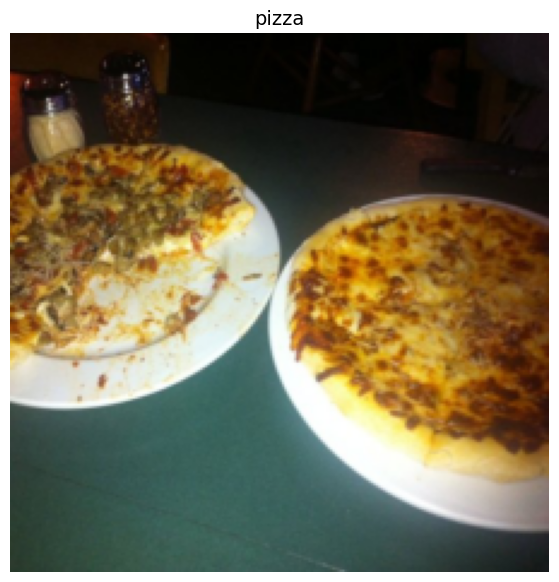

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e7f470f050>,
 <torch.utils.data.dataloader.DataLoader at 0x1e7f470fa40>)

In [19]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

In [20]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

Image size: torch.Size([3, 224, 224])
Label: 0, label size: torch.Size([])


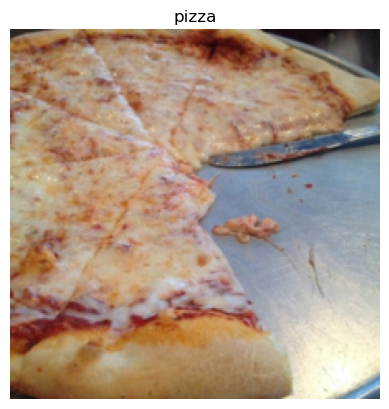

In [21]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze().permute(1,2,0))
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

Original image shape: torch.Size([3, 224, 224])


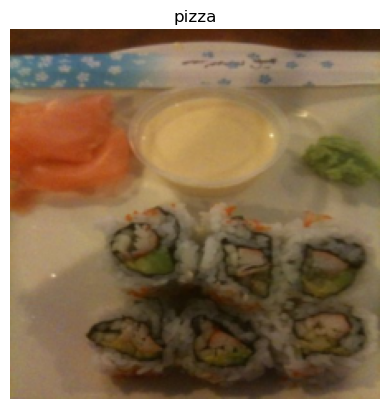

In [22]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")



In [23]:
import numpy as np

In [24]:
import torch

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

# Call the function to set the seeds
set_seeds()

In [25]:
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [26]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0, verbose=False):
        """
        Initialize EarlyStopping object.

        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each improvement.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        """
        Check if the model should stop training.

        Args:
            val_loss (float): Validation loss.
            model (torch.nn.Module): Model to be monitored.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

In [27]:
import torch
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        # Forward pass
        y_pred = model(x)
        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader.dataset)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  model.eval()

  test_loss, test_acc= 0,0

  with torch.inference_mode():
    #loop through dataloader and batches
    for batch, (x,y) in enumerate(dataloader):
      x,y= x.to(device), y.to(device)
      test_pred_logits= model(x)

      #calc loss
      loss= loss_fn(test_pred_logits, y)
      test_loss+= loss.item()
      #calc accuracy
      test_pred_labels= test_pred_logits.argmax(dim=1)
      test_acc+= ((test_pred_labels==y).sum().item()/len(test_pred_labels))


  test_loss= test_loss/len(dataloader)
  test_acc= test_acc/ len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter,
          early_stopping: EarlyStopping = None):

  results={"train_loss": [],
           "train_acc":[],
           "test_loss": [],
           "test_acc":[]
          }

  #loop through training and testing steps for a num of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc=train_step(model=model,
                                     dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer= optimizer,
                                     device= device)
    test_loss, test_acc= test_step(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)

    #print out whats happning
    print(
         f"Epoch: {epoch+1} | "
         f"train_loss: {train_loss:.4f} | "
         f"train_acc: {train_acc:.4f} | "
         f"test_loss: {test_loss:.4f} | "
         f"test_acc: {test_acc:.4f}"
     )
    #Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
    if writer:
        # Add results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        # Close the writer
        writer.close()
    else:
        pass
    ### End new ###

    # Check if early stopping should be applied
    if early_stopping is not None:
        if early_stopping(test_loss, model):
            print("Early stopping triggered.")
            break

  return results


In [28]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [29]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [32]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = 3

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_vit():
    # 1. Get pretrained weights for ViT-Base
  pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

  # 2. Setup a ViT model instance with pretrained weights
  model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

  # 3. Freeze the base parameters
  for parameter in model.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
  set_seeds()
  model.heads = nn.Linear(in_features=768, out_features=3).to(device)
  # 5. Give the model a name
  model.name = "vision transformer"
  print(f"[INFO] Created new {model.name} model.")
  return model

def create_mobilenet_v2():
  pretrained_mobile_v2_weights= torchvision.models.MobileNet_V2_Weights.DEFAULT
  model= torchvision.models.mobilenet_v2(weights= pretrained_mobile_v2_weights).to(device)
   #freeze the base paramets

  for parameter in model.parameters():
      
      parameter.required_grad= False

  set_seeds()
  model.classifier=nn.Sequential(
      nn.Dropout(p=0.3),
      nn.Linear(in_features=1280, out_features=3)
  ).to(device)

  model.name="mobilenet_v2"
  print(f"[INFO] Created new {model.name} model.")
  return model



In [33]:
import numpy as np

In [34]:
import torch

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

# Call the function to set the seeds
set_seeds()


In [38]:
# 1. Create epochs list
num_epochs = [2]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0"]

In [39]:
%%time

# 1. Set the random seeds
set_seeds(seed=42)
# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader


    # 4. Loop through each number of epochs
for epochs in num_epochs:
    # 5. Loop through each model name and create a new model based on the name
    for model_name in models:
        from timeit import default_timer as timer
        start_time = timer()
        # 6. Create information print outs
        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")

        print(f"[INFO] Number of epochs: {epochs}")
        # 7. Select the model
        if model_name == "effnetb0":
            model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
        elif model_name=="effnetb2":
            model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
        elif model_name=="vision transformer":
            model= create_vit()
        else:
            model= create_mobilenet_v2()

        # 8. Create a new loss and optimizer for every model
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
        # 9. Train target model with target dataloaders and track experiments
        train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=epochs,
              device=device,
              writer=create_writer(experiment_name="dog_vision",
                                   model_name=model_name,
                                   extra=f"{epochs}_epochs"))

        # 10. Save the model to file so we can get back the best model
        save_filepath = f"07_{model_name}_dog_vision_{epochs}_epochs.pth"
        save_model(model=model,
                   target_dir="models",
                   model_name=save_filepath)
        end_time=timer()
        print(f"total time taken by the experiment: {end_time-start_time}")
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Number of epochs: 2
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-05-12\dog_vision\effnetb0\2_epochs...


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1336 | train_acc: 0.3733 | test_loss: 1.1833 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.1265 | train_acc: 0.3822 | test_loss: 1.1212 | test_acc: 0.3467
[INFO] Saving model to: models\07_effnetb0_dog_vision_2_epochs.pth
total time taken by the experiment: 30.246516500017606
--------------------------------------------------

CPU times: total: 8.59 s
Wall time: 30.2 s


In [42]:
%tensorboard --logdir runs --port 6007

In [41]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 10772), started 18 days, 17:15:43 ago. (Use '!kill 10772' to kill it.)

In [83]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [84]:
image.shape

torch.Size([3, 224, 224])

In [85]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [91]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [86]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [87]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [96]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [98]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit_with_code,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [89]:
num_classes=3

In [92]:
vit_with_code = ViT(num_classes=num_classes,
                    num_transformer_layers=12,  # Reduce the number of layers
                    embedding_dim=768,          # Reduce the embedding dimension
                    num_heads=12)  

In [99]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [100]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [101]:
epochs=10

In [102]:
%%time
torch
# 1. Set the random seeds
set_seeds(seed=42)
# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader



    # 5. Loop through each model name and create a new model based on the name

from timeit import default_timer as timer
start_time = timer()

print(f"[INFO] Number of epochs: {epochs}")
# 7. Select the model
model_name="Vision_Transformer with code"
vit_with_code.to(device) # creates a new model each time (important because we want each experiment to start from scratch)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)
# 9. Train target model with target dataloaders and track experiments
train(model=vit_with_code,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      device=device,
      writer=create_writer(experiment_name="fashion_mnist",
                           model_name=model_name,
                           extra=f"{epochs}_epochs")
     )
# 10. Save the model to file so we can get back the best model
save_filepath = f"07_{model_name}_FashionMnist_{epochs}_epochs.pth"
save_model(model=vit_with_code,
           target_dir="models",
           model_name=save_filepath)
end_time=timer()
print(f"total time taken by the experiment: {end_time-start_time}")
print("-"*50 + "\n")

[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs\2024-05-09\fashion_mnist\Vision_Transformer with code\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1062 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1046 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 3 | train_loss: 1.1074 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 4 | train_loss: 1.1068 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 5 | train_loss: 1.1076 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 6 | train_loss: 1.1115 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 7 | train_loss: 1.1108 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 8 | train_loss: 1.1095 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 9 | train_loss: 1.1107 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
Epoch: 10 | train_loss: 1.1125 | train_acc: 0.3200 | test_loss: 1.0774 | test_acc: 0.4133
[INFO] Saving model to: models\07_Vision_Transformer with code_FashionMnist_10_epochs.pth
total time taken by

In [103]:
import torch
import torch.nn as nn
import math
from functools import partial

def init_2d_freqs(dim: int, num_heads: int, theta: float = 10.0, rotate: bool = True):
    freqs_x = []
    freqs_y = []
    mag = 1 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    for i in range(num_heads):
        angles = torch.rand(1) * 2 * torch.pi if rotate else torch.zeros(1)        
        fx = torch.cat([mag * torch.cos(angles), mag * torch.cos(torch.pi/2 + angles)], dim=-1)
        fy = torch.cat([mag * torch.sin(angles), mag * torch.sin(torch.pi/2 + angles)], dim=-1)
        freqs_x.append(fx)
        freqs_y.append(fy)
    freqs_x = torch.stack(freqs_x, dim=0)
    freqs_y = torch.stack(freqs_y, dim=0)
    freqs = torch.stack([freqs_x, freqs_y], dim=0)
    return freqs

def init_t_xy(end_x: int, end_y: int):
    t = torch.arange(end_x * end_y, dtype=torch.float32)
    t_x = (t % end_x).float()
    t_y = torch.div(t, end_x, rounding_mode='floor').float()
    return t_x, t_y

def compute_mixed_cis(freqs: torch.Tensor, t_x: torch.Tensor, t_y: torch.Tensor, num_heads: int):
    N = t_x.shape[0]
    # No float 16 for this range
    with torch.cuda.amp.autocast(enabled=False):
        freqs_x = (t_x.unsqueeze(-1) @ freqs[0].unsqueeze(-2)).view(N, num_heads, -1).permute(1, 0, 2)
        freqs_y = (t_y.unsqueeze(-1) @ freqs[1].unsqueeze(-2)).view(N, num_heads, -1).permute(1, 0, 2)
        freqs_cis = torch.polar(torch.ones_like(freqs_x), freqs_x + freqs_y)
    return freqs_cis

def compute_axial_cis(dim: int, end_x: int, end_y: int, theta: float = 100.0):
    freqs_x = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    freqs_y = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))

    t_x, t_y = init_t_xy(end_x, end_y)
    freqs_x = torch.outer(t_x, freqs_x)
    freqs_y = torch.outer(t_y, freqs_y)
    freqs_cis_x = torch.polar(torch.ones_like(freqs_x), freqs_x)
    freqs_cis_y = torch.polar(torch.ones_like(freqs_y), freqs_y)
    return torch.cat([freqs_cis_x, freqs_cis_y], dim=-1)

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    if freqs_cis.shape == (x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-2 else 1 for i, d in enumerate(x.shape)]
    elif freqs_cis.shape == (x.shape[-3], x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-3 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2).clone())
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2).clone())
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq).to(xq.device), xk_out.type_as(xk).to(xk.device)




class Attention(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        q = q * self.scale

        attn = (q @ k.transpose(-2, -1))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class RoPEAttention(Attention):
    """Multi-head Attention block with rotary position embeddings."""
    def __init__(self, *args, rope_theta=10.0, rope_mixed=True, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.rope_mixed = rope_mixed        
        
        if self.rope_mixed:
            self.compute_cis = partial(compute_mixed_cis, num_heads=self.num_heads)
            
            freqs = init_2d_freqs(
                dim=self.dim // self.num_heads, num_heads=self.num_heads, theta=rope_theta, 
                rotate=True
            ).view(2, -1)
            self.freqs = nn.Parameter(freqs, requires_grad=True)
            
            t_x, t_y = init_t_xy(end_x=14, end_y=14)
            self.register_buffer('freqs_t_x', t_x)
            self.register_buffer('freqs_t_y', t_y)
        else:
            self.compute_cis = partial(compute_axial_cis, dim=self.dim // self.num_heads, theta=rope_theta)
            freqs_cis = self.compute_cis(end_x=14, end_y=14)
            self.freqs_cis = freqs_cis
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ###### Apply rotary position embedding
        w = h = math.sqrt(x.shape[1] - 1)
        if self.rope_mixed:
            t_x, t_y = self.freqs_t_x, self.freqs_t_y
            if self.freqs_t_x.shape[0] != x.shape[1] - 1:
                t_x, t_y = init_t_xy(end_x=w, end_y=h)
                t_x, t_y = t_x.to(x.device), t_y.to(x.device)
            freqs_cis = self.compute_cis(self.freqs, t_x, t_y)
        else:
            freqs_cis = self.freqs_cis
            if self.freqs_cis.shape[0] != x.shape[1] - 1:
                freqs_cis = self.compute_cis(end_x=w, end_y=h)
            freqs_cis = freqs_cis.to(x.device)
        
        q[:, :, 1:], k[:, :, 1:] = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)        
        #########
        
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x

In [106]:
class TransformerEncoderBlock_Rot(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim=768,
                 num_heads=12,
                 mlp_size=3072,
                 mlp_dropout=0.1,
                 attn_dropout=0,
                 attention_cls=RoPEAttention):  # Change this to RoPEAttention
        super().__init__()

        self.msa_block = attention_cls(dim=embedding_dim, num_heads=num_heads)

        self.mlp_block = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(mlp_dropout)
        )

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x_res = x
        x = self.norm1(x + self.msa_block(x))
        x = self.norm2(x + self.mlp_block(x_res))
        return x

In [133]:
class ViT_Rot(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0.0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=num_classes):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // (patch_size * patch_size)

        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        
        # Use RoPEAttention instead of Attention in transformer_encoder
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock_Rot(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout,
                                                                            attention_cls=RoPEAttention) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

In [134]:
vit_with_code_rot = ViT_Rot(num_classes=num_classes,
                    num_transformer_layers=12,  # Reduce the number of layers
                    embedding_dim=768,          # Reduce the embedding dimension
                    num_heads=12)  

In [135]:
%%time
torch
# 1. Set the random seeds
set_seeds(seed=42)
# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader



    # 5. Loop through each model name and create a new model based on the name

from timeit import default_timer as timer
start_time = timer()

print(f"[INFO] Number of epochs: {epochs}")
# 7. Select the model
model_name="Vision_Transformer with code"
vit_with_code_rot.to(device) # creates a new model each time (important because we want each experiment to start from scratch)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)
# 9. Train target model with target dataloaders and track experiments
train(model=vit_with_code_rot,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      device=device,
      writer=create_writer(experiment_name="food_vision",
                           model_name=model_name,
                           extra=f"{epochs}_epochs")
     )
# 10. Save the model to file so we can get back the best model
save_filepath = f"07_{model_name}_foodvision_{epochs}_epochs.pth"
save_model(model=vit_with_code,
           target_dir="models",
           model_name=save_filepath)
end_time=timer()
print(f"total time taken by the experiment: {end_time-start_time}")
print("-"*50 + "\n")

[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs\2024-05-09\food_vision\Vision_Transformer with code\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2967 | train_acc: 0.3422 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.2631 | train_acc: 0.3378 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.2893 | train_acc: 0.3289 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.2690 | train_acc: 0.3556 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.2774 | train_acc: 0.3200 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 6 | train_loss: 1.2896 | train_acc: 0.3289 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 7 | train_loss: 1.2965 | train_acc: 0.3244 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.2660 | train_acc: 0.3333 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.2878 | train_acc: 0.3333 | test_loss: 1.3432 | test_acc: 0.2533
Epoch: 10 | train_loss: 1.2771 | train_acc: 0.3333 | test_loss: 1.3432 | test_acc: 0.2533
[INFO] Saving model to: models\07_Vision_Transformer with code_foodvision_10_epochs.pth
total time taken by t

In [43]:
"""
EfficientFormer
"""
import os
import copy
import torch
import torch.nn as nn

from typing import Dict
import itertools

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model


to_2tuple = lambda x: (x, x)

EfficientFormer_width = {
    'l1': [48, 96, 224, 448],
    'l3': [64, 128, 320, 512],
    'l7': [96, 192, 384, 768],
}

EfficientFormer_depth = {
    'l1': [3, 2, 6, 4],
    'l3': [4, 4, 12, 6],
    'l7': [6, 6, 18, 8],
}


class Attention(torch.nn.Module):
    def __init__(self, dim=384, key_dim=32, num_heads=8,
                 attn_ratio=4,
                 resolution=7):
        super().__init__()
        self.num_heads = num_heads
        self.scale = key_dim ** -0.5
        self.key_dim = key_dim
        self.nh_kd = nh_kd = key_dim * num_heads
        self.d = int(attn_ratio * key_dim)
        self.dh = int(attn_ratio * key_dim) * num_heads
        self.attn_ratio = attn_ratio
        h = self.dh + nh_kd * 2
        self.N = resolution ** 2
        self.N2 = self.N
        self.qkv = nn.Linear(dim, h)
        self.proj = nn.Linear(self.dh, dim)

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)
        attention_offsets = {}
        idxs = []
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])
        self.attention_biases = torch.nn.Parameter(
            torch.zeros(num_heads, len(attention_offsets)))
        self.register_buffer('attention_bias_idxs',
                             torch.LongTensor(idxs).view(N, N))

    @torch.no_grad()
    def train(self, mode=True):
        super().train(mode)
        if mode and hasattr(self, 'ab'):
            del self.ab
        else:
            self.ab = self.attention_biases[:, self.attention_bias_idxs]

    def forward(self, x):  # x (B,N,C)
        B, N, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.reshape(B, N, self.num_heads, -1).split([self.key_dim, self.key_dim, self.d], dim=3)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attn = (
                (q @ k.transpose(-2, -1)) * self.scale
                +
                (self.attention_biases[:, self.attention_bias_idxs]
                 if self.training else self.ab)
        )
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.dh)
        x = self.proj(x)
        return x


def stem(in_chs, out_chs):
    return nn.Sequential(
        nn.Conv2d(in_chs, out_chs // 2, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_chs // 2),
        nn.ReLU(),
        nn.Conv2d(out_chs // 2, out_chs, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_chs),
        nn.ReLU(), )


class Embedding(nn.Module):
    """
    Patch Embedding that is implemented by a layer of conv.
    Input: tensor in shape [B, C, H, W]
    Output: tensor in shape [B, C, H/stride, W/stride]
    """

    def __init__(self, patch_size=16, stride=16, padding=0,
                 in_chans=3, embed_dim=768, norm_layer=nn.BatchNorm2d):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        stride = to_2tuple(stride)
        padding = to_2tuple(padding)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size,
                              stride=stride, padding=padding)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return x


class Flat(nn.Module):

    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        return x


class Pooling(nn.Module):
    """
    Implementation of pooling for PoolFormer
    --pool_size: pooling size
    """

    def __init__(self, pool_size=3):
        super().__init__()
        self.pool = nn.AvgPool2d(
            pool_size, stride=1, padding=pool_size // 2, count_include_pad=False)

    def forward(self, x):
        return self.pool(x) - x


class LinearMlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class Mlp(nn.Module):
    """
    Implementation of MLP with 1*1 convolutions.
    Input: tensor with shape [B, C, H, W]
    """

    def __init__(self, in_features, hidden_features=None,
                 out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

        self.norm1 = nn.BatchNorm2d(hidden_features)
        self.norm2 = nn.BatchNorm2d(out_features)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)

        x = self.norm1(x)

        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)

        x = self.norm2(x)

        x = self.drop(x)
        return x


class Meta3D(nn.Module):

    def __init__(self, dim, mlp_ratio=4.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 drop=0., drop_path=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5):

        super().__init__()

        self.norm1 = norm_layer(dim)
        self.token_mixer = Attention(dim)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = LinearMlp(in_features=dim, hidden_features=mlp_hidden_dim,
                             act_layer=act_layer, drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. \
            else nn.Identity()
        self.use_layer_scale = use_layer_scale
        if use_layer_scale:
            self.layer_scale_1 = nn.Parameter(
                layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            self.layer_scale_2 = nn.Parameter(
                layer_scale_init_value * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        if self.use_layer_scale:
            x = x + self.drop_path(
                self.layer_scale_1.unsqueeze(0).unsqueeze(0)
                * self.token_mixer(self.norm1(x)))
            x = x + self.drop_path(
                self.layer_scale_2.unsqueeze(0).unsqueeze(0)
                * self.mlp(self.norm2(x)))

        else:
            x = x + self.drop_path(self.token_mixer(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class Meta4D(nn.Module):

    def __init__(self, dim, pool_size=3, mlp_ratio=4.,
                 act_layer=nn.GELU,
                 drop=0., drop_path=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5):
        super().__init__()

        self.token_mixer = Pooling(pool_size=pool_size)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. \
            else nn.Identity()
        self.use_layer_scale = use_layer_scale
        if use_layer_scale:
            self.layer_scale_1 = nn.Parameter(
                layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            self.layer_scale_2 = nn.Parameter(
                layer_scale_init_value * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        if self.use_layer_scale:

            x = x + self.drop_path(
                self.layer_scale_1.unsqueeze(-1).unsqueeze(-1)
                * self.token_mixer(x))
            x = x + self.drop_path(
                self.layer_scale_2.unsqueeze(-1).unsqueeze(-1)
                * self.mlp(x))
        else:
            x = x + self.drop_path(self.token_mixer(x))
            x = x + self.drop_path(self.mlp(x))
        return x


def meta_blocks(dim, index, layers,
                pool_size=3, mlp_ratio=4.,
                act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                drop_rate=.0, drop_path_rate=0.,
                use_layer_scale=True, layer_scale_init_value=1e-5, vit_num=1):
    blocks = []
    if index == 3 and vit_num == layers[index]:
        blocks.append(Flat())
    for block_idx in range(layers[index]):
        block_dpr = drop_path_rate * (
                block_idx + sum(layers[:index])) / (sum(layers) - 1)
        if index == 3 and layers[index] - block_idx <= vit_num:
            blocks.append(Meta3D(
                dim, mlp_ratio=mlp_ratio,
                act_layer=act_layer, norm_layer=norm_layer,
                drop=drop_rate, drop_path=block_dpr,
                use_layer_scale=use_layer_scale,
                layer_scale_init_value=layer_scale_init_value,
            ))
        else:
            blocks.append(Meta4D(
                dim, pool_size=pool_size, mlp_ratio=mlp_ratio,
                act_layer=act_layer,
                drop=drop_rate, drop_path=block_dpr,
                use_layer_scale=use_layer_scale,
                layer_scale_init_value=layer_scale_init_value,
            ))
            if index == 3 and layers[index] - block_idx - 1 == vit_num:
                blocks.append(Flat())

    blocks = nn.Sequential(*blocks)
    return blocks


class EfficientFormer(nn.Module):

    def __init__(self, layers, embed_dims=None,
                 mlp_ratios=4, downsamples=None,
                 pool_size=3,
                 norm_layer=nn.LayerNorm, act_layer=nn.GELU,
                 num_classes=120,
                 down_patch_size=3, down_stride=2, down_pad=1,
                 drop_rate=0., drop_path_rate=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 fork_feat=False,
                 init_cfg=None,
                 pretrained=None,
                 vit_num=0,
                 distillation=True,
                 **kwargs):
        super().__init__()

        if not fork_feat:
            self.num_classes = num_classes
        self.fork_feat = fork_feat

        self.patch_embed = stem(3, embed_dims[0])

        network = []
        for i in range(len(layers)):
            stage = meta_blocks(embed_dims[i], i, layers,
                                pool_size=pool_size, mlp_ratio=mlp_ratios,
                                act_layer=act_layer, norm_layer=norm_layer,
                                drop_rate=drop_rate,
                                drop_path_rate=drop_path_rate,
                                use_layer_scale=use_layer_scale,
                                layer_scale_init_value=layer_scale_init_value,
                                vit_num=vit_num)
            network.append(stage)
            if i >= len(layers) - 1:
                break
            if downsamples[i] or embed_dims[i] != embed_dims[i + 1]:
                # downsampling between two stages
                network.append(
                    Embedding(
                        patch_size=down_patch_size, stride=down_stride,
                        padding=down_pad,
                        in_chans=embed_dims[i], embed_dim=embed_dims[i + 1]
                    )
                )

        self.network = nn.ModuleList(network)

        if self.fork_feat:
            # add a norm layer for each output
            self.out_indices = [0, 2, 4, 6]
            for i_emb, i_layer in enumerate(self.out_indices):
                if i_emb == 0 and os.environ.get('FORK_LAST3', None):
                    layer = nn.Identity()
                else:
                    layer = norm_layer(embed_dims[i_emb])
                layer_name = f'norm{i_layer}'
                self.add_module(layer_name, layer)
        else:
            # Classifier head
            self.norm = norm_layer(embed_dims[-1])
            self.head = nn.Linear(
                embed_dims[-1], num_classes) if num_classes > 0 \
                else nn.Identity()
            self.dist = distillation
            if self.dist:
                self.dist_head = nn.Linear(
                    embed_dims[-1], num_classes) if num_classes > 0 \
                    else nn.Identity()

        self.apply(self.cls_init_weights)

        self.init_cfg = copy.deepcopy(init_cfg)
        # load pre-trained model
        if self.fork_feat and (
                self.init_cfg is not None or pretrained is not None):
            self.init_weights()

    # init for classification
    def cls_init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # init for mmdetection or mmsegmentation by loading
    # imagenet pre-trained weights
    def init_weights(self, pretrained=None):
        logger = get_root_logger()
        if self.init_cfg is None and pretrained is None:
            logger.warn(f'No pre-trained weights for '
                        f'{self.__class__.__name__}, '
                        f'training start from scratch')
            pass
        else:
            assert 'checkpoint' in self.init_cfg, f'Only support ' \
                                                  f'specify `Pretrained` in ' \
                                                  f'`init_cfg` in ' \
                                                  f'{self.__class__.__name__} '
            if self.init_cfg is not None:
                ckpt_path = self.init_cfg['checkpoint']
            elif pretrained is not None:
                ckpt_path = pretrained

            ckpt = _load_checkpoint(
                ckpt_path, logger=logger, map_location='cpu')
            if 'state_dict' in ckpt:
                _state_dict = ckpt['state_dict']
            elif 'model' in ckpt:
                _state_dict = ckpt['model']
            else:
                _state_dict = ckpt

            state_dict = _state_dict
            missing_keys, unexpected_keys = \
                self.load_state_dict(state_dict, False)

    def forward_tokens(self, x):
        outs = []
        for idx, block in enumerate(self.network):
            x = block(x)
            if self.fork_feat and idx in self.out_indices:
                norm_layer = getattr(self, f'norm{idx}')
                x_out = norm_layer(x)
                outs.append(x_out)
        if self.fork_feat:
            return outs
        return x

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.forward_tokens(x)
        if self.fork_feat:
            # otuput features of four stages for dense prediction
            return x
        x = self.norm(x)
        if self.dist:
            cls_out = self.head(x.mean(-2)), self.dist_head(x.mean(-2))
            if not self.training:
                cls_out = (cls_out[0] + cls_out[1]) / 2
        else:
            cls_out = self.head(x.mean(-2))
        # for image classification
        if isinstance(cls_out, tuple):
            cls_out= sum(cls_out)/len(cls_out)
        return cls_out


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 120, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .95, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'classifier': 'head',
        **kwargs
    }


@register_model
def efficientformer_l1(pretrained=False, **kwargs):
    model = EfficientFormer(
        layers=EfficientFormer_depth['l1'],
        embed_dims=EfficientFormer_width['l1'],
        downsamples=[True, True, True, True],
        vit_num=1,
        **kwargs)
    model.default_cfg = _cfg(crop_pct=0.9)
    return model


@register_model
def efficientformer_l3(pretrained=False, **kwargs):
    model = EfficientFormer(
        layers=EfficientFormer_depth['l3'],
        embed_dims=EfficientFormer_width['l3'],
        downsamples=[True, True, True, True],
        vit_num=4,
        **kwargs)
    model.default_cfg = _cfg(crop_pct=0.9)
    return model


@register_model
def efficientformer_l7(pretrained=False, **kwargs):
    model = EfficientFormer(
        layers=EfficientFormer_depth['l7'],
        embed_dims=EfficientFormer_width['l7'],
        downsamples=[True, True, True, True],
        vit_num=8,
        **kwargs)
    model.default_cfg = _cfg(crop_pct=0.9)
    return model

C:\Users\Inzayn\AppData\Local\Temp\ipykernel_15776\4255449886.py:487: UserWarning: Overwriting efficientformer_l1 in registry with __main__.efficientformer_l1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\Inzayn\AppData\Local\Temp\ipykernel_15776\4255449886.py:499: UserWarning: Overwriting efficientformer_l3 in registry with __main__.efficientformer_l3. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\Inzayn\AppData\Local\Temp\ipykernel_15776\4255449886.py:511: UserWarning: Overwriting efficientformer_l7 in registry with __main__.efficientformer_l7. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model


In [46]:
num_classes=3

In [47]:
def create_efficient_former():
  #not taking any pretrained weight
  # setup the eff.former model instance
  model = efficientformer_l1(num_classes=num_classes).to(device)
  # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
  set_seeds()
  
  # 5. Give the model a name
  model.name = "EfficientFormer"
  print(f"[INFO] Created new {model.name} model.")
  return model

In [53]:
eff_former=create_efficient_former()
eff_former.parameters()

[INFO] Created new EfficientFormer model.


<generator object Module.parameters at 0x000001E7B12AF840>

In [54]:
%%time
torch
# 1. Set the random seeds
set_seeds(seed=42)
# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader



    # 5. Loop through each model name and create a new model based on the name

from timeit import default_timer as timer
start_time = timer()

print(f"[INFO] Number of epochs: {epochs}")
# 7. Select the model
model_name="Efficient_former with code"
eff_former.to(device) # creates a new model each time (important because we want each experiment to start from scratch)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=eff_former.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)
# 9. Train target model with target dataloaders and track experiments
train(model=eff_former,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      device=device,
      writer=create_writer(experiment_name="food_vision",
                           model_name=model_name,
                           extra=f"{epochs}_epochs")
     )
# 10. Save the model to file so we can get back the best model
save_filepath = f"07_{model_name}_foodvision_{epochs}_epochs.pth"
save_model(model=eff_former,
           target_dir="models",
           model_name=save_filepath)
end_time=timer()
print(f"total time taken by the experiment: {end_time-start_time}")
print("-"*50 + "\n")

[INFO] Number of epochs: 2
[INFO] Created SummaryWriter, saving to: runs\2024-05-12\food_vision\Efficient_former with code\2_epochs...


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1088 | train_acc: 0.3911 | test_loss: 1.3167 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.1028 | train_acc: 0.2756 | test_loss: 1.1249 | test_acc: 0.2533
[INFO] Saving model to: models\07_Efficient_former with code_foodvision_2_epochs.pth
total time taken by the experiment: 40.54170669999439
--------------------------------------------------

CPU times: total: 8.22 s
Wall time: 40.5 s
